<a href="https://colab.research.google.com/github/IsakLarsson/Deep-Learning-labs/blob/main/Keras_Tuner_Isak_%C3%85man_Larsson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab notebook to implement Fashion-MNIST Autotuned
Created by Tomas Nordström, Umeå University. Runs model by Isak Åman Larsson

This code uses [Keras Tuner](https://keras-team.github.io/keras-tuner/) for hyperparameter tuning.

Based on
* https://www.mikulskibartosz.name/using-keras-tuner-to-tune-hyperparameters-of-a-tensorflow-model/
* https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
* https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/
* https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner
* https://www.sicara.ai/blog/2019-14-07-determine-network-hyper-parameters-with-bayesian-optimization


Revisions:
*   2020-04-05 First revision /ToNo
*   2020-11-15 Fixed printing of the n-best models. Adjusted some default parameters to get more stable results. /ToNo



## First we initilize our environment and run it within Tensorflow 2.0

In [ ]:
# Select Tensorflow 2.0
%tensorflow_version 2.x

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist 
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt


TensorFlow version: 2.3.0
Keras version: 2.4.0


In [ ]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-73980e94-5e28-2608-3b68-855667e2a9ed)


In [ ]:
# Get Keras Tuner
import importlib
try:
    # try to import the module normally and put it in globals
    globals()['kerastuner'] = importlib.import_module('kerastuner')
except ImportError as e:
    !git clone https://github.com/keras-team/keras-tuner.git
    !pip install ./keras-tuner

import kerastuner

# Get some tuner search functions
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization


Cloning into 'keras-tuner'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6714 (delta 8), reused 9 (delta 4), pack-reused 6693
Receiving objects: 100% (6714/6714), 2.07 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (4712/4712), done.
Processing ./keras-tuner
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-cp36-none-any.whl size=92439 sha256=ccf7e7879517c1cec3cf73ba8a51627bcbce75de73b62909bd19c213f882133d
  Stored in directory: /root/.cache/pip/wheels/fa/4e/d0/ed331a3363786e8a74848aa0589674f502cbb3f0321cdba844
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=9b3865a20f679fbc1065e1cc334090fd6ebf3bd9642ee43162bd34071dab9312
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## Get Data and Massage it into Shape

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tensorflow.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Add empty color dimension (needed to run on TPU)
train_images0 = np.expand_dims(train_images0, -1)
test_images = np.expand_dims(test_images, -1)

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

4423680/4422102 [==============================] - 0s 0us/step


## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further. But this time we are not doing much of this as we should have done that in previous Lab.

In [ ]:
# Print som baseic information of data set sizes and data sizes
train_no,x,y,col = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) : 
  print('# labels do not match # training images')

test_no,x,y,col = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) : 
  print('# labels do not match # test images')

val_no,x,y,col = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) : 
  print('# labels do not match # val images')
print('Training labels', np.unique(train_labels))

No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels [0 1 2 3 4 5 6 7 8 9]


Label: 1


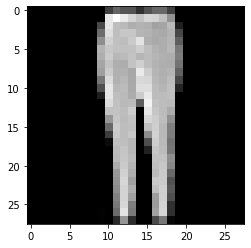

Label: 5


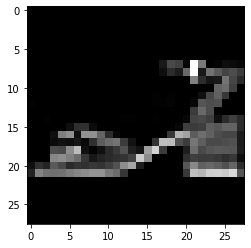

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', train_labels[index])
  plt.figure()
  plt.imshow(np.squeeze(train_images[index], axis=2))
  plt.gray()
  plt.grid(False)
  plt.show(block=False)

# Optimize model with Keras Tuner
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/ 

## Build a model structure with tunable hyperparameters 
hyperparameters are indicated with (hp.*)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# It can at least achieve 91.5% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   3, 
# conv_2_filter =  48, conv_2_kernel =   3
# dense_1_units =  80
# learning_rate = 0.001
# But sometimes we only get 90.5%, this is after all a random search!

def build_model_2Conv1Dense(hp):  
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Laboration: Kod för instrumentera din model att köras i Keras Tuner
Jag tar min avskalade modell som jag i del 1 av denna lab tagit fram för att inte överträna så fruktansvärt mycket.


In [ ]:
# Kompletera denna kod med din m odell
def build_model_MyModel(hp):  
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    #Second convolutional layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # First Dense layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=786, step=16),
        activation='relu'
    ),
    keras.layers.Dropout(0.25),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])
  
  ##### You can also try some other learning rates in the next line, or use another optimizer with other parameters
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Do a random search among the hyperparameters

In [ ]:
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes
# To get better robustness we should do more than one execution per trail, 
# but for now we just want to explore the tool
# If you have time more trails would be beneficial


In [ ]:
# Random search
if True:
  tuner = RandomSearch(
      build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
      objective='val_accuracy',
      max_trials=MAX_TRIALS,
      executions_per_trial=EXECUTION_PER_TRIAL,
      directory='output',
      project_name='FashionMNIST_R1') # This name need to be unique for a new tuning session

In [ ]:
# Do the tuner search with RandomSearch as defined above
if True:
  batch_size = 128   ## Mini batch size, we will tune this later
  noepochauto = 9    ## Number of epoch per hyper parameter testing
  tuner.search(train_images, train_labels, 
              epochs=noepochauto, 
              validation_data=(val_images, val_labels), 
              batch_size=batch_size,
              callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

Trial 20 Complete [00h 00m 52s]
val_accuracy: 0.901666671037674

Best val_accuracy So Far: 0.9131666719913483
Total elapsed time: 00h 17m 47s
INFO:tensorflow:Oracle triggered exit


## Now we have found a better set of hyper parameters
Time to explore....


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters()[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))
print()
# Print the model sumary
model.summary()

       conv_1_filter =  96
       conv_1_kernel =   3
       conv_2_filter =  64
       conv_2_kernel =   3
       dense_1_units = 768
       learning_rate = 0.0001

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        960       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPo

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2718 - accuracy: 0.9060
Test accuracy: 0.906


## Code to explore the n-best model

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel   dense_1_units   learning_rate 

          0.906              96               3              64               3             768          0.0001 
          0.902              96               3              64               3             320          0.0001 
          0.902              80               3              32               5             720          0.0001 
          0.901             112               5              48               5             592          0.0001 
          0.903              96               5              48               5             320          0.0001 


# Laboration: Analys

Gör en första analys av vilken optimerad model Keras Tuner har funnit, vilka andra hyperparametervärden fann optimeraren, och vilka prestanda den bästa modellen har. 
Om du tittar på de resulterande hyperparametrarna och jämför de med de gränser du satt på dem, ligger de på min/max-värdet för någon av dem, och vad skulle det betyda i så fall?

Först så ser jag att när jag tillät learning raten att gå ner till 0.0001 så verkar det ha varit det bästa valet eftersom att alla de bästa modellerna använde den learning raten. Alltså var jag korrekt i min undersökning under förra labben. Vidare verkar det första convolutional lagret föredra ca 100 noder och en 3,3 kernel och det andra verkar vilja ligga runt min satta maxgräns på 64 noder. Kanske bör man höja det omfånget ytterligare lite till. Det sista lagret verkar också föredra att ligga i de högre nodantalen för att få ett så bra resultat som möjligt. Jag ser att test lossen är rätt låg men jag hade önskat att accuracyn var högre då den just nu toppar på 90.6% vilket inte är lika bra som i min del 1 av denna labb. Men detta är ju bara random search så vi får se hur det går här nedanför med en lite mer riktad sökning av parametrar. Jag tror att random söka på detta sätt är bra för att få en hint om vad som kan vara bättre, parametrar som man kanske inte skulle testat annars helt enkelt.



# Do a more directed search using BayesianOptimization

Random search has its limitation and the tool have support for more adanced search strategies. Below we will use the BayesianOptimization strategy.


In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 15         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)


In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    project_name='FashionMNIST_BX1' # This name need to be unique for a new tuning session
)

In [ ]:
# Do the hyperparameter search
noepochauto = 9   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
tuner.search(train_images, train_labels, 
             epochs=noepochauto, 
             validation_data=(val_images, val_labels), 
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

Trial 15 Complete [00h 01m 41s]
val_accuracy: 0.9122083485126495

Best val_accuracy So Far: 0.914124995470047
Total elapsed time: 00h 15m 06s


# Now we have a good set of hyper parameters


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))
    
model.summary()

       conv_1_filter =  80
       conv_1_kernel =   3
       conv_2_filter =  32
       conv_2_kernel =   3
       dense_1_units = 768
       learning_rate = 0.0001
          batch_size =  64
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 128)       3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        36896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 32)        128       
______________________________________________________________

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(
  test_images,
  test_labels
)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2589 - accuracy: 0.9107
Test accuracy: 0.911


## Code to explore the n-best model 

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel   dense_1_units   learning_rate      batch_size 

          0.911             128               5              32               3             192          0.0001              32 
          0.908              80               3              64               5             432          0.0001              32 
          0.904              96               3              48               5             784          0.0001              64 
          0.906              64               3              64               3             224          0.0001              64 
          0.905              80               3              32               3             768          0.0001              64 


# With our found hyperparameters, continue training
(Note that this probably is not be needed in this case.)

However, for larger projects we might not have fully trained the models during hyperparameter search, and now need to do this fine-tuning.

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1706 - accuracy: 0.9370 - val_loss: 0.2406 - val_accuracy: 0.9122
Epoch 2/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1603 - accuracy: 0.9418 - val_loss: 0.2655 - val_accuracy: 0.9087
Epoch 3/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1465 - accuracy: 0.9476 - val_loss: 0.2514 - val_accuracy: 0.9113
Epoch 00003: early stopping


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2694 - accuracy: 0.9077
Test accuracy: 0.908


# Do a clean training of the model
An experiment to see how consistent the accuracy is when redoing the training

In [ ]:
# Code to reset model weights in TF2, from https://github.com/keras-team/keras/issues/341
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [ ]:
# Reset the weights to some random values for a clean start
reset_weights(model)

In [ ]:
# Train the network with optimized hyperparameters
epochs = 30      ## (Maximum) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size'] # Get the optimal batch size

# Set callback functions to early stop training
callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)]

# Train the model.
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  callbacks=callbacks
)

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5157 - accuracy: 0.8164 - val_loss: 0.3479 - val_accuracy: 0.8764
Epoch 2/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3465 - accuracy: 0.8763 - val_loss: 0.3044 - val_accuracy: 0.8928
Epoch 3/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2976 - accuracy: 0.8937 - val_loss: 0.2919 - val_accuracy: 0.8970
Epoch 4/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2652 - accuracy: 0.9050 - val_loss: 0.2670 - val_accuracy: 0.9018
Epoch 5/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2404 - accuracy: 0.9125 - val_loss: 0.2637 - val_accuracy: 0.9035
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2215 - accuracy: 0.9198 - val_loss: 0.2537 - val_accuracy: 0.9083
Epoch 7/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2011 - accuracy: 0.9271 - val_loss: 0.2544 - val_accuracy:

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2802 - accuracy: 0.9062
Test accuracy: 0.906


# Laboration: Analys av användning av Keras Tuner


Gör en komplett analys av de optimerade modelerna du fått fram mha Keras Tuner.
Vilka var dina hyperparametervärden, ursprungligen ifrån första labben, med slumpmässig sökning, med Bayesiask sökning. Vilka prestanda fick du för de tre fallen? Ändrade du sökgränserna efter den första slumpmässiga sökningen?
Vilka hyperparametrar verkade vara mest betydelsfulla? Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)? Annat som du iaktagit?

De parametrar som gavs av den slumpmässiga sökningen ville dra sig lite mer åt max-storleken på de olika lagren och en minsta storlek på faltningskärnorna. Gemensamn för de båda modellerna är att de verkar föredra en learning rate på 0.0001 då alla de bästa modellerna använde det. Jag ändrade till detta efter en första körning då jag sett tidigare att det verkar prestera mycket bättre. Random search modellen presterade dock bäst trots allt med en test accuracy på 91.1% jämfört med den andras 90.6%, vilket var lite av en besvikelse. Men jag är övertygad om att med lite mer tid och fipplande med modellen så kan ett bra resultat uppnås.

    conv_1_filter =  96     RANDOM
    conv_1_kernel =   3
    conv_2_filter =  64
    conv_2_kernel =   3
    dense_1_units = 768
    learning_rate = 0.0001


Den mer metodiska sökningen ledde till att det första lagret uppnådde sin maximala storlek både i antal noder och storlek på faltningskärnan. 128 respektive 5,5. Samt att det andra lagret gick till den minsta angivna storleken på 32 noder och 3,3 faltningskärna, vilket jag fann intressant. Det verkar trenda mot att ha större lager och kärna längst "fram" och att det blir mindre och mindre ju längre bak man kommer. Batch sizen var lite blandad bland de bästa modellerna men 32 låg i toppen. Trots all denna sökning så slog den inte den slumpmässigt valda modellen och kunde endast prestera 90.6% test accuracy. 


    conv_1_filter =  128     BAYEAN
    conv_1_kernel =   5
    conv_2_filter =  32
    conv_2_kernel =   3
    dense_1_units = 192
    learning_rate = 0.0001
    batch_size =  32


De modeller som jag testat i del 1 av labben har vid tillfällen kommit upp i så högt som 91.7% men med betydligt högre loss (uppemot 40%) och det sker ej varje gång. Alltså skulle jag säga att det handlar mer om tur och slump, vilka noder som droppas osv. Däremot presterar min "bästa" modell med early stopping ganska jämnt på 90.7% vilket är ungefär lika bra som den framtagna modellen med bayeansk sökning. Jag tror dock att jag skulle valt en annan modell att undersöka på då denna redan från början haft väldigt lätt att överträna till datat. Jag kommer nog att göra det på fritiden utöver denna uppgift!. Avslutningsvis verkar det som ett väldigt bra verktyg för att optimisera modeller och jag tycker även att det belyser det faktum att det behövs enorma mängder datorkraft för att beräkna dessa saker. Man brute-forcar i stort sett en bra kombination av parametrar och det tar sin tid.

    conv_1_filter =  64     MIN EGEN
    conv_1_kernel =   5
    conv_2_filter =  128
    conv_2_kernel =   3
    dense_1_units = 128
    learning_rate = 0.0001
    batch_size =  32

